In [73]:
# ====== Packages =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from prettytable import PrettyTable
from tqdm import tqdm


# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

# ---- algorithms ----
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, RocCurveDisplay, roc_curve, precision_recall_curve

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh


# This line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

## Load the dataset and one_hot_encode the test_indication column (we dont want the algorhithem to "think" that 2 is more related to 1 than 0)

In [86]:
dataset = pd.read_pickle('data_for_tree.pkl')
dataset = dataset.reset_index()
dataset_hot_encoded = pd.get_dummies(dataset, columns=['test_indication'])
columns_names = [column for column in dataset_hot_encoded.columns]
columns_names.remove('corona_result')
columns_names.append('corona_result')

dataset_hot_encoded = dataset_hot_encoded.reindex(columns=columns_names)
dataset_hot_encoded.drop(columns='index', inplace=True)


In [87]:
dataset_hot_encoded

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication_0,test_indication_1,test_indication_2,corona_result
0,18,0,0,0,0,0,1,0,0,0
1,18,1,0,0,0,0,1,0,0,0
2,18,0,1,0,0,0,1,0,0,0
3,18,1,0,0,0,0,1,0,0,0
4,18,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
274697,11,0,0,0,0,0,1,0,0,0
274698,11,0,0,0,0,0,1,0,0,0
274699,11,0,0,0,0,0,1,0,0,0
274700,11,0,0,0,0,0,0,1,0,1


## Split the Data:
* Split the data to test,train and validation sets
* up/down sample the train data


In [88]:
X_train_raw, y_train_raw, X_test, y_test = mh.data_split(dataset_hot_encoded ,n_splits=1, test_size=0.4, train_size=0.6)
X_train, y_train = mh.up_down_sampling(X_train_raw, y_train_raw, ratio=1, up=True)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test , n_splits=1, test_size=0.5, train_size=0.5)


In [89]:
y_train.value_counts()

0    156005
1    156005
Name: corona_result, dtype: int64

## Xgboost Classifier:

/home/nirlalum/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.56051
[1]	validation_0-aucpr:0.56617
[2]	validation_0-aucpr:0.56669
[3]	validation_0-aucpr:0.56760
[4]	validation_0-aucpr:0.57900
[5]	validation_0-aucpr:0.57958
[6]	validation_0-aucpr:0.58057
[7]	validation_0-aucpr:0.58174
[8]	validation_0-aucpr:0.58308
[9]	validation_0-aucpr:0.58407
[10]	validation_0-aucpr:0.58501
[11]	validation_0-aucpr:0.58554
[12]	validation_0-aucpr:0.58654
[13]	validation_0-aucpr:0.58755
[14]	validation_0-aucpr:0.58793
[15]	validation_0-aucpr:0.61595
[16]	validation_0-aucpr:0.61610
[17]	validation_0-aucpr:0.61646
[18]	validation_0-aucpr:0.65136
[19]	validation_0-aucpr:0.65285
[20]	validation_0-aucpr:0.65438
[21]	validation_0-aucpr:0.65557
[22]	validation_0-aucpr:0.65841
[23]	validation_0-aucpr:0.65903
[24]	validation_0-aucpr:0.66229
[25]	validation_0-aucpr:0.66253
[26]	validation_0-aucpr:0.66495
[27]	validation_0-aucpr:0.66537
[28]	validation_0-aucpr:0.67361
[29]	validation_0-aucpr:0.68182
[30]	validation_0-aucpr:0.68288
[31]	validation_0-

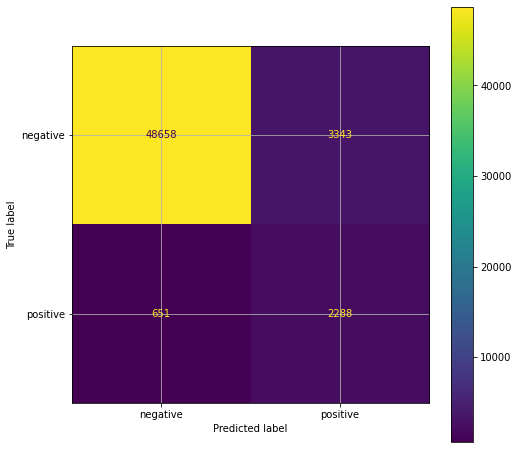

In [90]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eta=0.1, max_depth=6, reg_lambda=100)
clf_xgb.fit(X_train, y_train,verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])
xgb_pred = clf_xgb.predict(X_test)

mh.model_evaluation(y_test, xgb_pred)

## Hyperparameters optimization with GridSearchCV:
* Note: we wiil do 2 rounds of optimization to speed up the search.

In [5]:

# Round1:
params1 = {
           'max_depth': [3, 4, 5],
           'learning_rate': [0.1, 0.01, 0.05],
           'gamma': [0, 0.25, 1.0],
           'reg_lambda': [0, 1.0, 10.0],
           'scale_pos_weight': [1, 3, 5]
         }


#Round2:
params2 = {
           'max_depth': [5, 6, 7],
           'learning_rate': [0.1, 0.2, 0.3],
           'gamma': [1.0, 2.0, 3.0]
         }

optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',subsample=0.9, use_label_encoder=False),
                              param_grid=params2,
                              scoring='roc_auc',
                              verbose=10,
                              n_jobs=10,
                              cv=3
                             )


## GridSearchCV results:
* round 1: gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3 (max_score=0.91)
* round 2: gamma=2, learning_rate=0.3, max_depth=6, reg_lambda=0, scale_pos_weight=3 (max_score=0.959)

In [6]:
#optimal_params.fit(X_train, y_train,verbose=0, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 2/27] START gamma=1.0, learning_rate=0.1, max_depth=6..................
[CV 3/3; 1/27] START gamma=1.0, learning_rate=0.1, max_depth=5..................
[CV 2/3; 1/27] START gamma=1.0, learning_rate=0.1, max_depth=5..................
[CV 1/3; 1/27] START gamma=1.0, learning_rate=0.1, max_depth=5..................
[CV 2/3; 2/27] START gamma=1.0, learning_rate=0.1, max_depth=6..................
[CV 1/3; 1/27] END gamma=1.0, learning_rate=0.1, max_depth=5;, score=0.929 total time= 2.3min
[CV 3/3; 1/27] END gamma=1.0, learning_rate=0.1, max_depth=5;, score=0.931 total time= 2.4min
[CV 2/3; 4/27] START gamma=1.0, learning_rate=0.2, max_depth=5..................
[CV 3/3; 4/27] START gamma=1.0, learning_rate=0.2, max_depth=5..................
[CV 2/3; 1/27] END gamma=1.0, learning_rate=0.1, max_depth=5;, score=0.928 total time= 2.4min
[CV 1/3; 5/27] START gamma=1.0, learning_rate=0.2, max_depth=6..................
[CV 3/3; 

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [7]:
print(f"best parameters: {optimal_params.best_params_},\nROC_AUC score: {optimal_params.best_score_}")

best parameters: {'gamma': 2.0, 'learning_rate': 0.3, 'max_depth': 6},
ROC_AUC score: 0.9595241207359106


In [91]:
X_train

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication_0,test_indication_1,test_indication_2
74721,17,0,0,0,0,0,1,0,0
51756,17,0,0,0,0,0,1,0,0
52814,17,0,0,0,0,0,1,0,0
51845,17,1,0,0,0,0,1,0,0
159005,15,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
271790,11,0,0,1,0,0,1,0,0
238572,13,0,0,0,0,0,0,1,0
212349,14,0,0,0,0,0,0,1,0
255078,13,1,1,0,0,0,1,0,0


## Run the Xgboost again with the optimized hyperparameters:

/home/nirlalum/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.65597
[1]	validation_0-aucpr:0.65229
[2]	validation_0-aucpr:0.66407
[3]	validation_0-aucpr:0.66872
[4]	validation_0-aucpr:0.67066
[5]	validation_0-aucpr:0.66995
[6]	validation_0-aucpr:0.67458
[7]	validation_0-aucpr:0.67752
[8]	validation_0-aucpr:0.68357
[9]	validation_0-aucpr:0.68685
[10]	validation_0-aucpr:0.68990
[11]	validation_0-aucpr:0.69172
[12]	validation_0-aucpr:0.69444
[13]	validation_0-aucpr:0.69430
[14]	validation_0-aucpr:0.69548
[15]	validation_0-aucpr:0.69660
[16]	validation_0-aucpr:0.69946
[17]	validation_0-aucpr:0.70136
[18]	validation_0-aucpr:0.70192
[19]	validation_0-aucpr:0.70586
[20]	validation_0-aucpr:0.70844
[21]	validation_0-aucpr:0.70920
[22]	validation_0-aucpr:0.71006
[23]	validation_0-aucpr:0.71006
[24]	validation_0-aucpr:0.71021
[25]	validation_0-aucpr:0.71074
[26]	validation_0-aucpr:0.71091
[27]	validation_0-aucpr:0.71114
[28]	validation_0-aucpr:0.71139
[29]	validation_0-aucpr:0.71233
[30]	validation_0-aucpr:0.71255
[31]	validation_0-

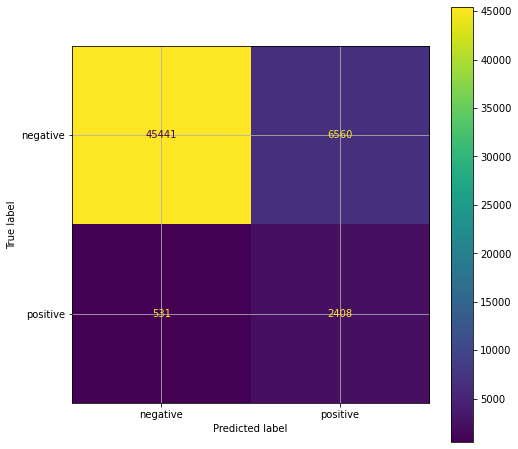

In [92]:
xgb_post_val = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.3, max_depth=6, reg_lambda=0, gamma=2.0, scale_pos_weight=3)
xgb_post_val.fit(X_train, y_train,verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])
xgb_post_val_pred = xgb_post_val.predict(X_test)

mh.model_evaluation(y_test, xgb_post_val_pred)

# Check the missclassified examples:

# false negative examples:

In [93]:
X_test_no_dummies = dataset.iloc[y_test.index] # so we will have the not hot encoded test indication feature

y_test_aux = y_test.reset_index()
X_test_aux = X_test_no_dummies.reset_index()

# Get all indexes of the negative prediction of the classifier
negative_indexes = xgb_post_val_pred == 0 

# Get the examples that were predicted as negative
negative_pred_exm = y_test_aux.iloc[negative_indexes] 
negative_pred_exm.drop(columns=['index'],inplace=True)

# Get all the false negative examples
false_neg_pred = X_test_no_dummies.iloc[negative_pred_exm[negative_pred_exm['corona_result']==1].index]

/home/nirlalum/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [94]:
false_neg_pred.head()

,index,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,corona_result
145493,147760,15,0,0,0,0,0,0,1
197275,200180,14,0,0,0,0,0,0,1
183691,186308,14,0,0,0,0,0,0,1
202391,205367,14,0,0,0,0,0,0,1
221211,224347,13,0,0,0,0,0,0,1


100%|██████████| 7/7 [00:00<00:00, 54.83it/s]


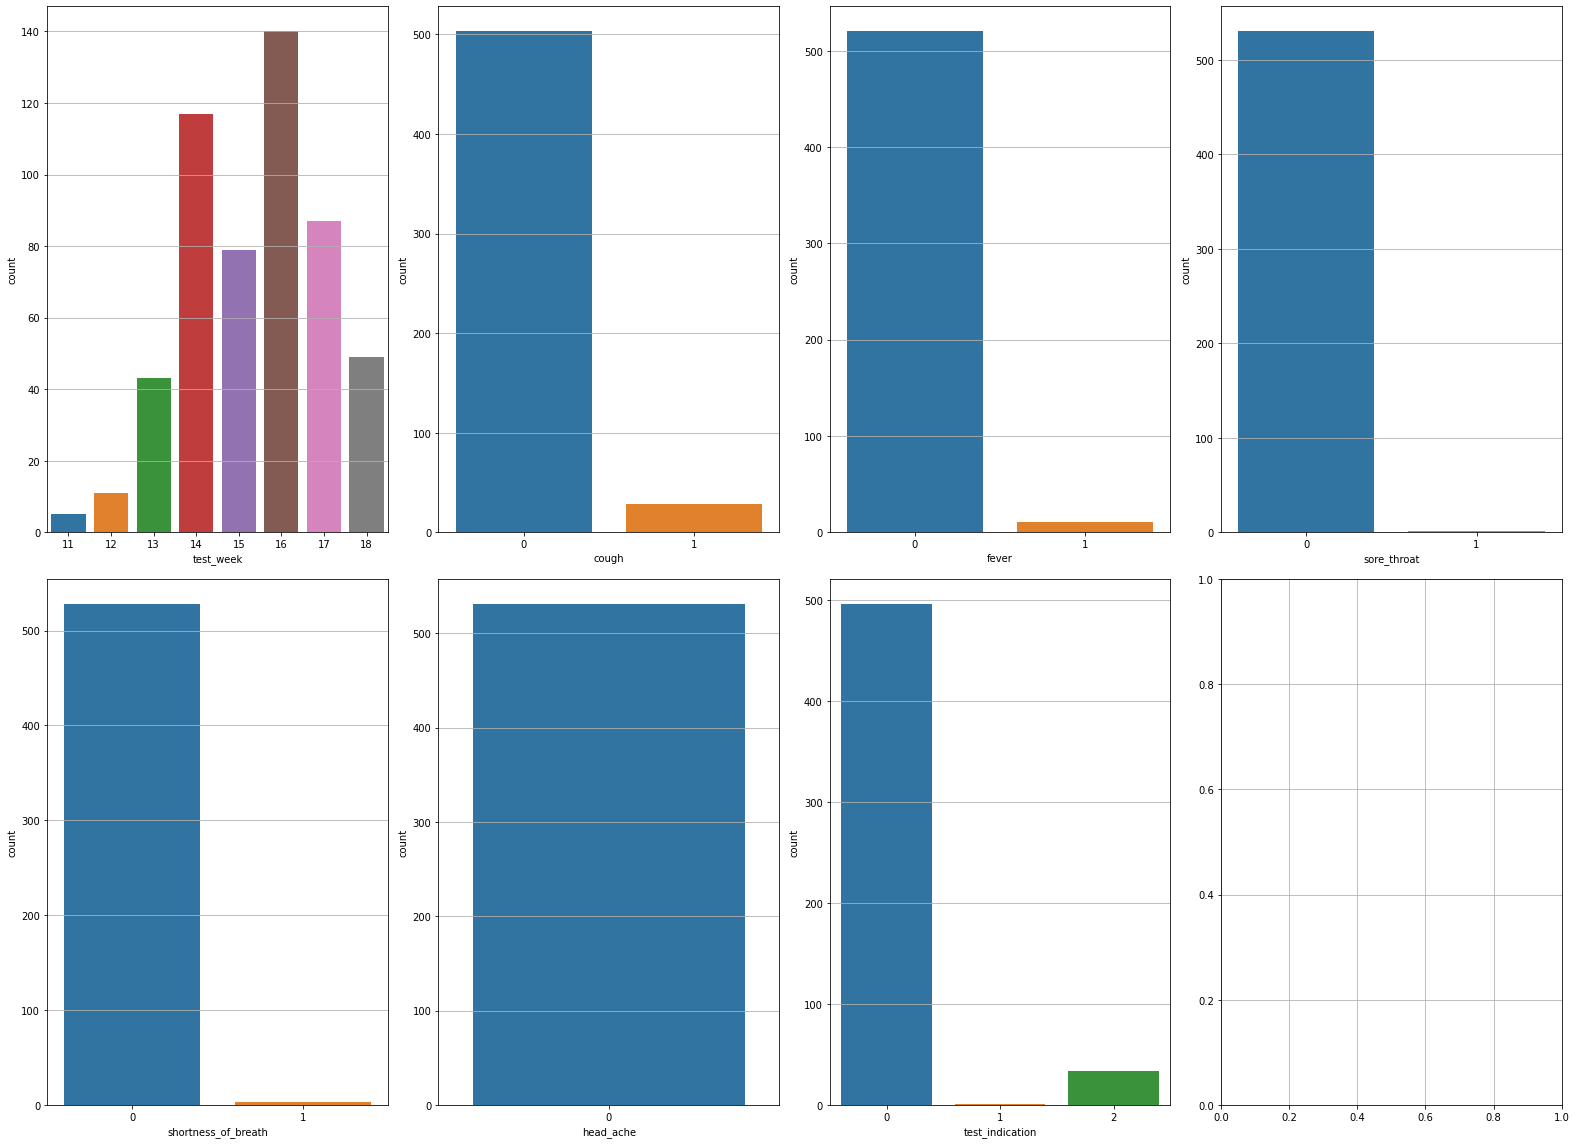

In [96]:
hel.plot_dataset(false_neg_pred[false_neg_pred.columns[1:8]], sns.countplot, 'countplot')

In [97]:
# count how many people are with no sympthoms at all and test_indication = other
asympthomatic_exm = false_neg_pred.loc[(false_neg_pred['cough']==0) 
                                      & (false_neg_pred['fever']==0)
                                      & (false_neg_pred['sore_throat']==0)
                                      & (false_neg_pred['shortness_of_breath']==0)
                                      & (false_neg_pred['head_ache']==0)
                                      & (false_neg_pred['test_indication']==0)
                                      ]

asympthomatic_exm.head()
len(asympthomatic_exm)

print(f"The percentage of the false negative without sympthoms and test indication is other is: {100*len(asympthomatic_exm)/len(false_neg_pred)}")

The percentage of the false negative without sympthoms and test indication is other is: 92.46704331450094


* It seems that most of the false negative are people without sympthoms. its makes sense that the model will infere that people with no sympthoms are not sick.
* The problem with corona that many people who are sick have no sympthoms at all and I think that in this area AI models are prone to fail.
* Also most oh the false negative made the test at the end of the corona wave so it decreases the chance to be sick

## False positive examples:

In [82]:
X_test_no_dummies = dataset.iloc[y_test.index] # so we will have the not encoded test indication feature

y_test_aux = y_test.reset_index()
X_test_aux = X_test_no_dummies.reset_index()

positive_indexes = xgb_post_val_pred == 1
positive_pred_exm = y_test_aux.iloc[positive_indexes]

positive_pred_exm.drop(columns=['index'],inplace=True)
false_positive_pred = X_test_no_dummies.iloc[positive_pred_exm[positive_pred_exm['corona_result']==0].index]

/home/nirlalum/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [83]:
len(false_positive_pred)

6822

100%|██████████| 7/7 [00:00<00:00, 47.82it/s]


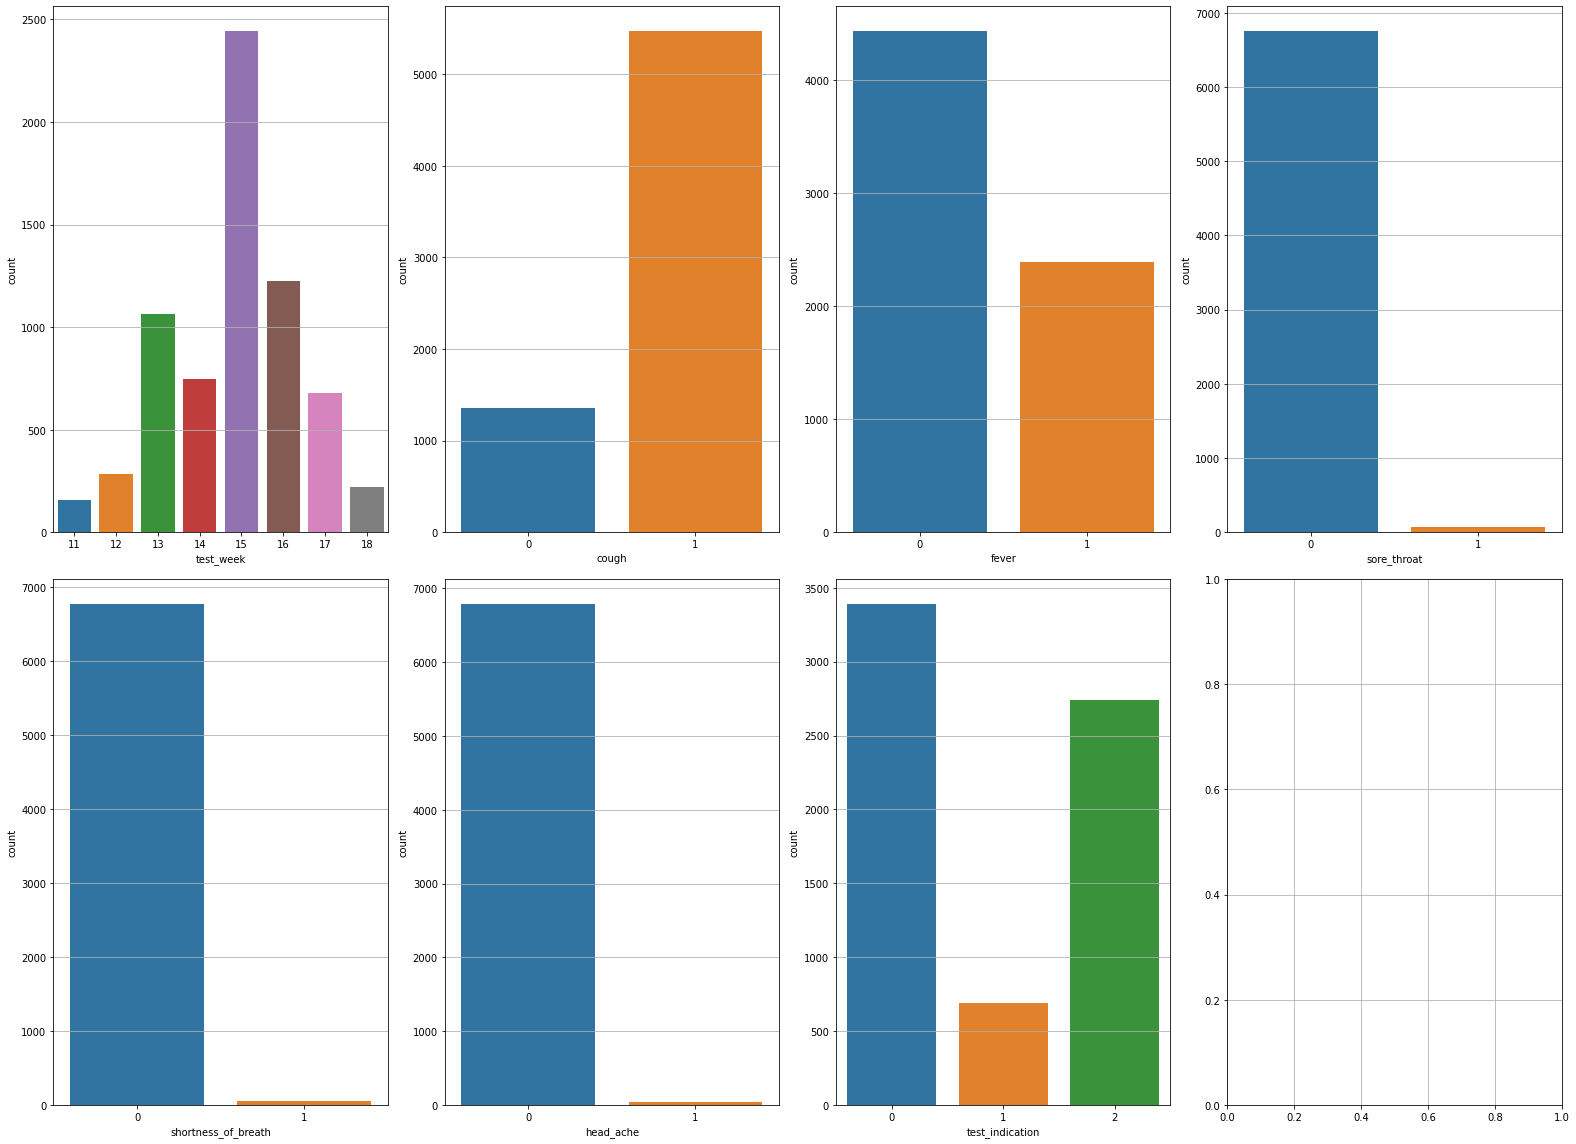

In [84]:
hel.plot_dataset(false_positive_pred[false_positive_pred.columns[1:8]], sns.countplot, 'countplot')

In [85]:
cough_fever_gr = false_positive_pred.groupby(['cough', 'fever'])
sub_group = cough_fever_gr.get_group((1,0))
len(sub_group)


3670

## To do: (for reducing the false positive)

## 1. It would be intresting to check the distribution of Pr('positive'|number of sympthoms) because here it seems that the model gave to much weight to people with cough (even to people who has only cough). The examine will be implemented in covid_data_pre_proccessing.ipynb.

## 2. Finding an optimal ththreshold (it will be harder to predict positive so the false positive will be reduced)

## NOTE: for now we will leave the false negative (think that there is not much to do there)).

## Try with new feature: number of sympthoms:


In [123]:
dataset2 = pd.read_pickle('data_for_tree2.pkl')
X_train_raw, y_train_raw, X_test, y_test = mh.data_split(dataset2 ,n_splits=1, test_size=0.4, train_size=0.6)
X_train, y_train = mh.up_down_sampling(X_train_raw, y_train_raw, ratio=1, up=True)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test , n_splits=1, test_size=0.5, train_size=0.5)

[0]	validation_0-aucpr:0.64040
[1]	validation_0-aucpr:0.63585
[2]	validation_0-aucpr:0.64214
[3]	validation_0-aucpr:0.65341
[4]	validation_0-aucpr:0.65991
[5]	validation_0-aucpr:0.66254
[6]	validation_0-aucpr:0.66725
[7]	validation_0-aucpr:0.66821
[8]	validation_0-aucpr:0.67045
[9]	validation_0-aucpr:0.67388
[10]	validation_0-aucpr:0.67592
[11]	validation_0-aucpr:0.67828
[12]	validation_0-aucpr:0.68234
[13]	validation_0-aucpr:0.68484
[14]	validation_0-aucpr:0.68708
[15]	validation_0-aucpr:0.68802
[16]	validation_0-aucpr:0.68779
[17]	validation_0-aucpr:0.68802
[18]	validation_0-aucpr:0.68891
[19]	validation_0-aucpr:0.68891
[20]	validation_0-aucpr:0.68996
[21]	validation_0-aucpr:0.69078
[22]	validation_0-aucpr:0.69202
[23]	validation_0-aucpr:0.69158
[24]	validation_0-aucpr:0.69101
[25]	validation_0-aucpr:0.69084
[26]	validation_0-aucpr:0.69053
[27]	validation_0-aucpr:0.69048
[28]	validation_0-aucpr:0.69095
[29]	validation_0-aucpr:0.69053
[30]	validation_0-aucpr:0.69101
[31]	validation_0-

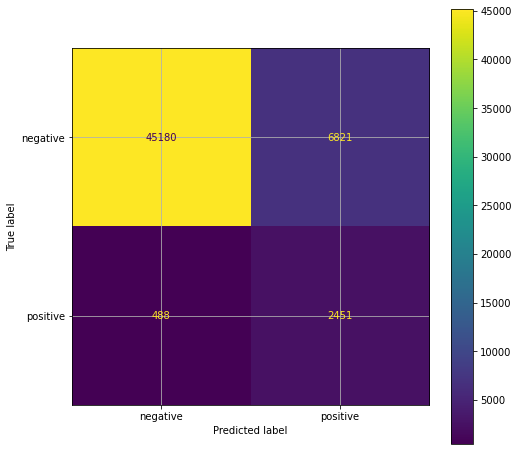

In [126]:
xgb_new_feature = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.3, max_depth=6, reg_lambda=0, gamma=2.0, scale_pos_weight=3)
xgb_new_feature.fit(X_train, y_train,verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])
xgb_new_feature_pred = xgb_new_feature.predict(X_test)

mh.model_evaluation(y_test, xgb_new_feature_pred)

In [108]:
xgb_new_feature = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.3, max_depth=6, reg_lambda=0, gamma=2.0, scale_pos_weight=3)
xgb_new_feature.fit(X_train, y_train,verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])
xgb_new_feature_pred = xgb_new_feature.predict_proba(X_test)[:,1] # take the probs only for positive






/home/nirlalum/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.68208
[1]	validation_0-aucpr:0.68397
[2]	validation_0-aucpr:0.68491
[3]	validation_0-aucpr:0.69056
[4]	validation_0-aucpr:0.69194
[5]	validation_0-aucpr:0.69280
[6]	validation_0-aucpr:0.69437
[7]	validation_0-aucpr:0.69529
[8]	validation_0-aucpr:0.69639
[9]	validation_0-aucpr:0.69733
[10]	validation_0-aucpr:0.69742
[11]	validation_0-aucpr:0.69728
[12]	validation_0-aucpr:0.69930
[13]	validation_0-aucpr:0.70012
[14]	validation_0-aucpr:0.70354
[15]	validation_0-aucpr:0.70397
[16]	validation_0-aucpr:0.70542
[17]	validation_0-aucpr:0.70569
[18]	validation_0-aucpr:0.70540
[19]	validation_0-aucpr:0.70543
[20]	validation_0-aucpr:0.70514
[21]	validation_0-aucpr:0.70631
[22]	validation_0-aucpr:0.70621
[23]	validation_0-aucpr:0.70618
[24]	validation_0-aucpr:0.70644
[25]	validation_0-aucpr:0.70674
[26]	validation_0-aucpr:0.70716
[27]	validation_0-aucpr:0.70736
[28]	validation_0-aucpr:0.70738
[29]	validation_0-aucpr:0.70684
[30]	validation_0-aucpr:0.70660
[31]	validation_0-

+-----------+---------------------+
|   Metric  |        Score        |
+-----------+---------------------+
|  accuracy |  0.8706042955951948 |
|   recall  |  0.8353181354202109 |
|  f1 score | 0.40851984358099674 |
| presicion | 0.27037444933920707 |
+-----------+---------------------+


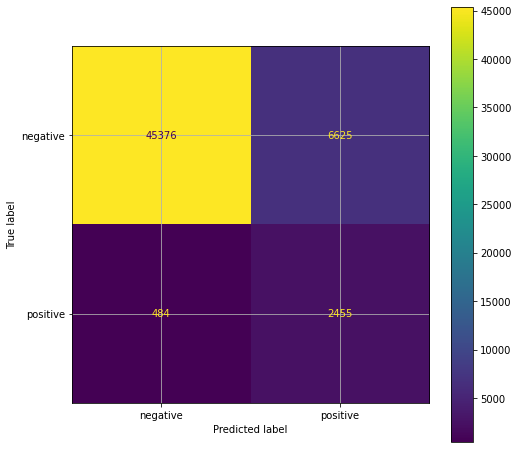

In [116]:
threshold = 0.5


xgb_new_feature_pred2 = 1*(xgb_new_feature_pred>threshold)


mh.model_evaluation(y_test, xgb_new_feature_pred2)